# Neural network model to generate wind power 

This jupyter notebook demonsstrates the use of neural network model to generate wind power for the beligium offshore wind power. Neural network models have been showing powerful in capturining the non-linear relationship of complex data. I use a a gridded climate data ERA5 (reanalysis) to generate wind power.    

# Step1: load necessary python pacakges and set python env

In [1]:
%load_ext nb_black
import os

os.environ["PATH"]

from numpy.random import seed

seed(123)

import pandas as pd

from numpy.random import seed

seed(123)

import pandas as pd
from pathlib import Path
import os
from os.path import isfile, join

from datetime import date
import csv
import numpy as np
import matplotlib.pyplot as plt

import metpy.units
from metpy.units import units
import metpy.calc
import metpy

from netCDF4 import Dataset
import nctoolkit as nc


import math
import time
import timeit

from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    QuantileTransformer,
    PowerTransformer,
    RobustScaler,
)
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.decomposition import FastICA

# https://stackoverflow.com/questions/29438265/stratified-train-test-split-in-scikit-learn

from sklearn.model_selection import train_test_split

import tensorflow as tf

tf.autograph.set_verbosity(0)
tf.random.set_seed(1)
from tensorflow.keras.layers import Input, LSTM, Dense, concatenate, Activation
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

import tensorflow.keras.backend as K
from tensorflow.keras.utils import get_custom_objects


from netCDF4 import Dataset
import nctoolkit as nc


# import keras

# import shap

# # print the JS visualization code to the notebook
# shap.initjs()

# assign working directory to variable
file_path = os.getcwd()
# setting path for data folder
DATA_PATH = Path.cwd().parent / "Belgian_power_3hr"
print(DATA_PATH)
from pathlib import Path
import os
from os.path import isfile, join

from datetime import date
import csv
import numpy as np
import matplotlib.pyplot as plt


from metpy.units import units
import metpy.calc
import metpy


import math
import time
import timeit

from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    QuantileTransformer,
    PowerTransformer,
    RobustScaler,
)
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.decomposition import FastICA

# https://stackoverflow.com/questions/29438265/stratified-train-test-split-in-scikit-learn

from sklearn.model_selection import train_test_split

Please install CDO version 1.9.4 or above: https://code.mpimet.mpg.de/projects/cdo/ or https://anaconda.org/conda-forge/cdo
Please install CDO version 1.9.4 or above: https://code.mpimet.mpg.de/projects/cdo/ or https://anaconda.org/conda-forge/cdo
O:\TU_Dell_03March_2021\Belgian_gfs_Forecast\Belgian_power_3hr


<IPython.core.display.Javascript object>

# Step2: loading and cleaning wind power data

In [2]:
power = pd.read_csv(DATA_PATH / "Belgian_power_2016_2020_3hrly.csv")
power["TIMESTAMP"] = pd.to_datetime(power["TIMESTAMP"])
date_from = pd.Timestamp(date(2016, 1, 1))
date_to = pd.Timestamp(date(2021, 1, 1))

<IPython.core.display.Javascript object>

In [3]:
power = power[(power["TIMESTAMP"] >= date_from) & (power["TIMESTAMP"] <= date_to)]

y = power["Obs_3hr"].values.reshape(len(power), 1)
mask = np.isnan(y)
y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])


power_r = power["rated_3hr"].values.reshape(power.shape[0], 1)
mask = np.isnan(power_r)
power_r[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), power_r[~mask])


mask = np.isnan(y)
y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])


mask = np.isnan(power_r)
power_r[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), power_r[~mask])
power_r.max()
P = np.divide(y, power_r)
P.max()

0.9814689073728313

<IPython.core.display.Javascript object>

# Step3: Reading gridded climate data: ERA5/GFS

In [4]:
ft = "O:\\TU_hpc12\GFENS\\ERA5_skin_temperature.nc"
dt = Dataset(ft, mode="r")
lont = dt.variables["longitude"][:]
latt = dt.variables["latitude"][:]
# skt = dt.variables["skt"]
# # print(dt)
# skt.shape

fn = "O:\\TU_hpc12\GFENS\\ERA5_100m_Uuv_2016_2020_3hrly.nc"
f10 = "O:\\TU_hpc12\GFENS\\ERA5_10Uuv_t2m_mslp.nc"
frh = "O:\\TU_hpc12\GFENS\\ERA5_850hpa_RHspecfic_2016_2020.nc"  # ERA5_850hpa_RH_2016_2020.nc"

ds = Dataset(fn, mode="r")


lons = ds.variables["longitude"][:]
lats = ds.variables["latitude"][:]
Us = ds.variables["U"]
tim = ds.variables["time"]


# lat_bnds, lon_bnds = [49, 54], [-2, 8]
# lat_bnds, lon_bnds = [50, 53], [0.75, 5.25] #
# lat_bnds, lon_bnds = [50, 54.5], [1, 5]
lat_bnds, lon_bnds = [50, 53], [0.75, 5.25]
# lat_bnds, lon_bnds = [50.5, 53.0], [1, 4.75]
lat_bnds, lon_bnds = [49.5, 53.5], [1, 4.75]
lat_bnds, lon_bnds = [51.38, 51.86], [2.5, 3.23]
# lat_bnds, lon_bnds = [49.5, 53.5], [1, 4.75]

lat_inds = np.where((lats > lat_bnds[0]) & (lats < lat_bnds[1]))[0]
lon_inds = np.where((lons > lon_bnds[0]) & (lons < lon_bnds[1]))[0]
du = Dataset(fn, mode="r")
U = np.squeeze(du.variables["U"][:, lat_inds, lon_inds])
u100 = np.squeeze(du.variables["u100"][:, lat_inds, lon_inds])
v100 = np.squeeze(du.variables["v100"][:, lat_inds, lon_inds])
skt = np.squeeze(dt.variables["skt"][:, lat_inds, lon_inds])
t2m = np.squeeze(Dataset(f10, mode="r").variables["t2m"][:, lat_inds, lon_inds])
tdif = (t2m - skt) / 2
[tdif.shape, t2m.shape, skt.shape]

u = np.array(u100, dtype=float)
v = np.array(v100, dtype=float)
Udir = metpy.calc.wind_direction(
    u * units.meter / units.second, v * units.meter / units.second,
)
Udir = np.float32(Udir)
# [Ut.shape, u100.shape, v100.shape]
Ut = np.stack((tdif, u100, v100, U), 3)
Ut = Ut.reshape(Ut.shape[0], Ut.shape[1] * Ut.shape[2] * Ut.shape[3])
Ut = U.reshape(U.shape[0], U.shape[1] * U.shape[2])
# Ut = np.float32(Ut)
Ut.shape

(14616, 4)

<IPython.core.display.Javascript object>

# Step4: This section is to use the time axis as sin and cos to capture the cyclic nature of time

[(14616, 6), (14616, 10)]

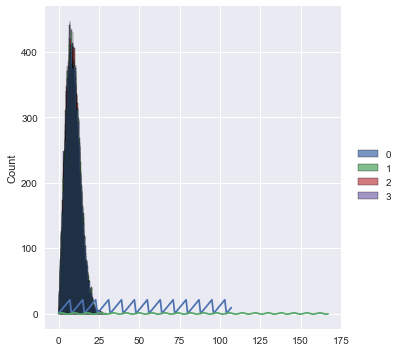

<IPython.core.display.Javascript object>

In [5]:
# plot hist of

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use("seaborn")

pd.DataFrame(Ut).describe()

ax = sns.displot(Ut[:, :4])

import datetime


def hr_func(ts):
    return ts.hour


power["time_hour"] = power["TIMESTAMP"].apply(hr_func)

hours = power["time_hour"]

sample = hours[:108]  # roughly tpower.head()

ax = sample.plot()

power["hour_sin"] = np.sin(2 * np.pi * power["time_hour"] / 23.0)
power["hour_cos"] = np.cos(2 * np.pi * power["time_hour"] / 23.0)
power.head()

sample = power[0:168]
ax = sample["hour_sin"].plot()

## cyclic for date and month


def encode(power, col, max_val):
    power[col + "_sin"] = np.sin(2 * np.pi * power[col] / max_val)
    power[col + "_cos"] = np.cos(2 * np.pi * power[col] / max_val)
    return power


def month_func(ts):
    return ts.month


power["month"] = power["TIMESTAMP"].apply(month_func)
power = encode(power, "month", 12)


def day_func(ts):
    return ts.day


power["day"] = power["TIMESTAMP"].apply(day_func)
power = encode(power, "day", 365)
power.head()

# combine time cyclic with meteorological variables
time_cyc = power[
    [
        "hour_sin",
        "hour_cos",
        "day_sin",
        "day_cos",
        "month_sin",
        "month_cos",
    ]
]
time_cyc = np.array(time_cyc).reshape(len(power), 6)


U_time_cyc = np.concatenate((Ut, time_cyc), axis=1)
[time_cyc.shape, U_time_cyc.shape]


# Step5:  Split the wind power and climate data into training and validation 

In [6]:
splt_1 = 0.59941
splt_2 = 0.79974


n = len(P)


def split_scale(P, Ut):
    y_train = P[0 : int(n * splt_2)]
    # y_val = P[int(n * splt_1) : int(n * splt_2)]

    y_test = P[int(n * splt_2) :]

    X_train = Ut[0 : int(n * splt_2), :]
    # X_val = Ut[int(n * splt_1) : int(n * splt_2), :]
    X_test = Ut[int(n * splt_2) :, :]

    #     bins = np.linspace(start=np.amin(y_train), stop=np.amax(y_train), num=60)

    #     y_binned = np.digitize(y_train, bins, right=True)

    #     X_train, X_val, y_train, y_val = train_test_split(
    #         X_train, y_train, test_size=0.2505, stratify=y_binned
    #     )

    #     sc = MinMaxScaler(feature_range=(0, 1))
    #     scaler = sc.fit(X_train)
    #     X_train_s = scaler.fit_transform(X_train)
    #     X_val_s = scaler.transform(X_val)
    #     X_test_s = scaler.transform(X_test)
    return y_train, y_test, X_train, X_test


y_train, y_test, X_train_t, X_test_t = split_scale(P, Ut)
y_train, y_test, X_train, X_test = split_scale(P, Ut)
# y_train, y_val, y_test, X_train_s_Udiro, X_val_s_Udiro, X_test_s_Udiro = split_scale(
#     P, Udiro
# )
# y_train, y_val, y_test, X_train_s_t2o, X_val_s_t2o, X_test_s_t2o = split_scale(P, t2o)

[y_train.shape, y_test.shape, X_train_t.shape, X_test_t.shape]

[(11688, 1), (2928, 1), (11688, 4), (2928, 4)]

<IPython.core.display.Javascript object>

# Step6: multi-layer perceptron model development and architecture

In [7]:
!pip install plot-model

<IPython.core.display.Javascript object>

In [8]:
tf.autograph.set_verbosity(0)
import logging

logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.experimental.do_not_convert(func=None)
tf.autograph.set_verbosity(0)


tf.random.set_seed(1)

kernel_init = tf.keras.initializers.GlorotUniform()
bias_init = initializers.Zeros()

#  kernel_initializer="he_uniform"
# tf.config.run_functions_eagerly(True)
# Add the GELU function to Keras
"""
gelu function is obtained from this website 
https://mlfromscratch.com/activation-functions-explained/#/ 
correlation_loss
https://stackoverflow.com/questions/46619869/how-to-specify-the-correlation-coefficient-as-the-loss-function-in-keras/46620771
"""


def correlation_coefficient_loss(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x - mx, y - my
    r_num = K.sum(tf.multiply(xm, ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den

    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return K.square(r)


def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))


get_custom_objects().update({"gelu": gelu})


exp = 5

activation_fun = "relu"


def model_con(shape):

    mlp_input = Input(shape=shape)
    x1 = Dense(
        64,
        activation=activation_fun,
        kernel_initializer=kernel_init,
        bias_initializer=bias_init,
    )(mlp_input)
    x2 = Dense(
        64,
        activation=activation_fun,
        kernel_initializer=kernel_init,
        bias_initializer=bias_init,
    )(x1)
    x3 = Dense(
        64,
        activation=activation_fun,
        kernel_initializer=kernel_init,
        bias_initializer=bias_init,
    )(x2)
    x4 = Dense(
        64,
        activation=activation_fun,
        kernel_initializer=kernel_init,
        bias_initializer=bias_init,
    )(x3)
    x5 = Dense(
        64,
        activation=activation_fun,
        kernel_initializer=kernel_init,
        bias_initializer=bias_init,
    )(x4)
    mlp_out = Dense(
        64,
        activation=activation_fun,
        kernel_initializer=kernel_init,
        bias_initializer=bias_init,
    )(x5)
    return (mlp_input, mlp_out)


def model_mlp():
    mlp_input, mlp_out = model_con(X_train_t.shape[1])
    # mlp_input_1, mlp_out_1 = model_con(X_train.shape[1])
    # mlp_input_2, mlp_out_2 = model_con(X_train_s_Udiro)
    # mlp_input_3, mlp_out_3 = model_con(X_train_s_t2o)
    # out = concatenate([mlp_out, mlp_out_1])
    out = Dense(
        128,
        activation=activation_fun,
        kernel_initializer=kernel_init,
        bias_initializer=bias_init,
    )(mlp_out)
    out = Dense(1, kernel_initializer=kernel_init, bias_initializer=bias_init)(out)

    model_mlp = Model(inputs=[mlp_input], outputs=out)

    model_mlp.compile(loss="mae", optimizer=tf.keras.optimizers.Adam(lr=0.01))  #
    return model_mlp


model = model_mlp()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160  

<IPython.core.display.Javascript object>

Use the below script to save architecture of the model. The model is saved with all information in graphical format. It can be used  in the report or presentation.

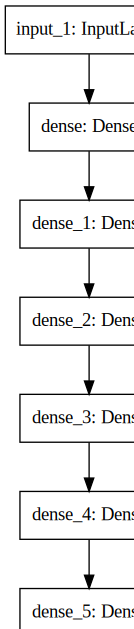

<IPython.core.display.Javascript object>

In [12]:
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model

import pydot
import pydotplus
import graphviz
from IPython.display import SVG
import os
from pathlib import Path
import os
from os.path import isfile, join
import graphviz

os.name

from tensorflow.keras.models import Model, load_model

# from keras.preprocessing import image
# from tensorflow.keras.utils import layer_utils

# from keras.utils.data_utils import get_file
# from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG

# from tensorflow.keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model
from tensorflow.python.keras.utils import conv_utils

# from tensorflow.keras.utils import plot_model


# from keras import backend as K
# from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

import timeit

import os

os.environ["PATH"] += os.pathsep + "C:\\Program Files (x86)\\Graphviz\\bin"

# plot_model(model, to_file="inception_model.png", show_shapes=True)
# SVG(model_to_dot(model).create(prog="dot", format="svg"))


os.environ["PATH"] += os.pathsep + "C:\Program Files (x86)\Graphviz\bin"

# from plot_model import plot_model

# plot_model(mm)
plot_model(model, to_file="inception_model.png", show_shapes=True)
SVG(model_to_dot(model).create(prog="dot", format="svg"))

# TimeSeriesSplit and training models

TimeSeriesSplit python pacakge is used to split the temporal data. For more detail information how this package works look at its manual and tutorial on the python package.

In [315]:

from sklearn.model_selection import TimeSeriesSplit
n_splits = 5
tscv = TimeSeriesSplit(n_splits)


<IPython.core.display.Javascript object>

In [316]:
import joblib
import gc
from tensorflow.keras import backend as K

# save the model history in a list after fitting so that we can plot later

histories = list()
all_preds = []

for fold, (train_index, test_index) in enumerate(tscv.split(X_train)):
    # for fold, (train_indext, test_indext) in enumerate(tscv.split(X_train)):
    print("Fold: {}".format(fold))
    # print("TRAIN indices:", train_index, "\n", "TEST indices:", test_index)
    print("\n")
    X_train_s, X_val_s = X_train[train_index], X_train[test_index]
    y_train_s, y_val_s = y_train[train_index], y_train[test_index]

    sc = MinMaxScaler(feature_range=(0, 1))
    scaler = sc.fit(X_train_s)

    X_train_u = scaler.fit_transform(X_train_s)
    X_val_u = scaler.transform(X_val_s)
    X_test_u = scaler.transform(X_test)

    # time vector

    X_train_st, X_val_st = X_train_t[train_index], X_train_t[test_index]
    y_train_s, y_val_s = y_train[train_index], y_train[test_index]

    sc_t = MinMaxScaler(feature_range=(0, 1))
    scaler_t = sc_t.fit(X_train_st)

    X_train_s_t = scaler_t.fit_transform(X_train_st)
    X_val_s_t = scaler_t.transform(X_val_st)
    X_test_s_t = scaler_t.transform(X_test_t)

    start = timeit.default_timer()

    batch_size = 64
    epochs = 2000

    OUTPUT_DIR = (
        "O:\TU_Dell_03March_2021\Belgian_gfs_Forecast\DL_Model_exp4\outputs\MLP_Model_ERA5_U_R1_"
        + str(exp)
        + str(fold)
        + "_"
    )

    StrOut = OUTPUT_DIR + "History" + ".csv"
    csv_logger = CSVLogger(StrOut, append=False, separator=";")

    STR = "weights" + ".hdf5"

    reduced_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=5,
        verbose=2,
        mode="auto",
        min_delta=0.0001,
        cooldown=0,
        min_lr=0,
    )

    F = OUTPUT_DIR + STR
    ch = ModelCheckpoint(
        F, monitor="val_loss", save_best_only=True, mode="min", verbose=1
    )
    es = EarlyStopping(monitor="val_loss", mode="min", patience=10, verbose=1)
    callbacks_list = [ch, es, reduced_lr, csv_logger]
    #
    model_Kfold = model_mlp()

    history = model_Kfold.fit(
        x=[X_train_s_t],
        y=y_train_s,
        validation_data=([X_val_s_t], y_val_s),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks_list,
        verbose=1,
    )

    pred = model_Kfold.predict([X_test_s_t])
    all_preds.append(pred)
    histories.append(history)

    stop = timeit.default_timer()
    execution_time = stop - start
    print("Program Executed in " + str(execution_time))  # It returns time in seconds
    # print(model_Kfold.evaluate(X_val_s, y_val_s))
    del model_Kfold
    K.clear_session()
    gc.collect()
    # return histories

Fold: 0


Epoch 1/2000
31/31 [==============================] - 1s 11ms/step - loss: 0.2807 - val_loss: 0.0920

Epoch 00001: val_loss improved from inf to 0.09201, saving model to O:\TU_Dell_03March_2021\Belgian_gfs_Forecast\DL_Model_exp4\outputs\MLP_Model_ERA5_U_R1_50_weights.hdf5
Epoch 2/2000
31/31 [==============================] - 0s 6ms/step - loss: 0.0894 - val_loss: 0.0800

Epoch 00002: val_loss improved from 0.09201 to 0.07995, saving model to O:\TU_Dell_03March_2021\Belgian_gfs_Forecast\DL_Model_exp4\outputs\MLP_Model_ERA5_U_R1_50_weights.hdf5
Epoch 3/2000
31/31 [==============================] - 0s 4ms/step - loss: 0.0793 - val_loss: 0.0967

Epoch 00003: val_loss did not improve from 0.07995
Epoch 4/2000
31/31 [==============================] - 0s 4ms/step - loss: 0.0822 - val_loss: 0.0748

Epoch 00004: val_loss improved from 0.07995 to 0.07477, saving model to O:\TU_Dell_03March_2021\Belgian_gfs_Forecast\DL_Model_exp4\outputs\MLP_Model_ERA5_U_R1_50_weights.hdf5
Epoch 5/2000


31/31 [==============================] - 0s 4ms/step - loss: 0.0626 - val_loss: 0.0645

Epoch 00042: val_loss improved from 0.06454 to 0.06454, saving model to O:\TU_Dell_03March_2021\Belgian_gfs_Forecast\DL_Model_exp4\outputs\MLP_Model_ERA5_U_R1_50_weights.hdf5

Epoch 00042: ReduceLROnPlateau reducing learning rate to 3.199999628122896e-06.
Epoch 43/2000
31/31 [==============================] - 0s 3ms/step - loss: 0.0631 - val_loss: 0.0645

Epoch 00043: val_loss improved from 0.06454 to 0.06454, saving model to O:\TU_Dell_03March_2021\Belgian_gfs_Forecast\DL_Model_exp4\outputs\MLP_Model_ERA5_U_R1_50_weights.hdf5
Epoch 44/2000
31/31 [==============================] - 0s 3ms/step - loss: 0.0618 - val_loss: 0.0645

Epoch 00044: val_loss did not improve from 0.06454
Epoch 45/2000
31/31 [==============================] - 0s 3ms/step - loss: 0.0618 - val_loss: 0.0645

Epoch 00045: val_loss did not improve from 0.06454
Epoch 46/2000
31/31 [==============================] - 0s 3ms/step - loss


Epoch 00026: val_loss did not improve from 0.06763
Epoch 27/2000
61/61 [==============================] - 0s 3ms/step - loss: 0.0627 - val_loss: 0.0696

Epoch 00027: val_loss did not improve from 0.06763
Epoch 28/2000
61/61 [==============================] - 0s 2ms/step - loss: 0.0625 - val_loss: 0.0677

Epoch 00028: val_loss did not improve from 0.06763

Epoch 00028: ReduceLROnPlateau reducing learning rate to 0.0003999999724328518.
Epoch 29/2000
61/61 [==============================] - 0s 2ms/step - loss: 0.0628 - val_loss: 0.0678

Epoch 00029: val_loss did not improve from 0.06763
Epoch 30/2000
61/61 [==============================] - 0s 2ms/step - loss: 0.0613 - val_loss: 0.0680

Epoch 00030: val_loss did not improve from 0.06763
Epoch 31/2000
61/61 [==============================] - 0s 2ms/step - loss: 0.0625 - val_loss: 0.0691

Epoch 00031: val_loss did not improve from 0.06763
Epoch 32/2000
61/61 [==============================] - 0s 2ms/step - loss: 0.0615 - val_loss: 0.0679



122/122 [==============================] - 0s 2ms/step - loss: 0.0665 - val_loss: 0.0630

Epoch 00012: val_loss did not improve from 0.06011
Epoch 13/2000
122/122 [==============================] - 0s 2ms/step - loss: 0.0663 - val_loss: 0.0607

Epoch 00013: val_loss did not improve from 0.06011
Epoch 14/2000
122/122 [==============================] - 0s 2ms/step - loss: 0.0667 - val_loss: 0.0647

Epoch 00014: val_loss did not improve from 0.06011
Epoch 15/2000
122/122 [==============================] - 0s 2ms/step - loss: 0.0662 - val_loss: 0.0617

Epoch 00015: val_loss did not improve from 0.06011
Epoch 16/2000
122/122 [==============================] - 0s 2ms/step - loss: 0.0657 - val_loss: 0.0653

Epoch 00016: val_loss did not improve from 0.06011

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.0003999999724328518.
Epoch 17/2000
122/122 [==============================] - 0s 2ms/step - loss: 0.0667 - val_loss: 0.0604

Epoch 00017: val_loss did not improve from 0.06011
Epo

153/153 [==============================] - 1s 4ms/step - loss: 0.0642 - val_loss: 0.0661

Epoch 00023: val_loss did not improve from 0.06557
Epoch 24/2000
153/153 [==============================] - 1s 4ms/step - loss: 0.0630 - val_loss: 0.0659

Epoch 00024: val_loss did not improve from 0.06557
Epoch 25/2000
153/153 [==============================] - 1s 5ms/step - loss: 0.0629 - val_loss: 0.0668

Epoch 00025: val_loss did not improve from 0.06557
Epoch 26/2000
153/153 [==============================] - 1s 5ms/step - loss: 0.0626 - val_loss: 0.0659

Epoch 00026: val_loss did not improve from 0.06557
Epoch 27/2000
153/153 [==============================] - 1s 3ms/step - loss: 0.0633 - val_loss: 0.0673

Epoch 00027: val_loss did not improve from 0.06557

Epoch 00027: ReduceLROnPlateau reducing learning rate to 7.999999215826393e-05.
Epoch 00027: early stopping
Program Executed in 13.928121400000236


<IPython.core.display.Javascript object>

In [317]:
# plot diagnostic learning curves
save_Fig = "O:\TU_Dell_03March_2021\Belgian_gfs_Forecast\DL_Model_exp4\Figs\\"

fig = plt.figure()


def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        # plt.subplot(111)

        plt.title("")
        plt.plot(
            histories[i].history["loss"],
            color="blue",
            label=("" if i == 0 else "_") + "Train",
            alpha=0.8,
        )
        plt.plot(
            histories[i].history["val_loss"],
            color="red",
            label=("" if i == 1 else "_") + "Validation",
            alpha=0.8,
        )
        plt.xlabel("Training steps", fontsize=22)
        plt.ylabel("MAE", fontsize=22)

        plt.legend()

        plt.rcParams["font.size"] = 22
        plt.savefig(
            save_Fig + "MLP_learning_curve2d_ERA5_U_R1_" + str(exp) + ".svg",
            dpi=1200,
            transparent=True,
            bbox_inches="tight",
        )
    #         # plot accuracy
    #         plt.subplot(212)
    #         plt.title('Classification Accuracy')
    #         plt.plot(histories[i].history['acc'], color='blue', label='train')
    #         plt.plot(histories[i].history['val_acc'], color='orange', label='test')
    plt.show()

<Figure size 576x396 with 0 Axes>

<IPython.core.display.Javascript object>

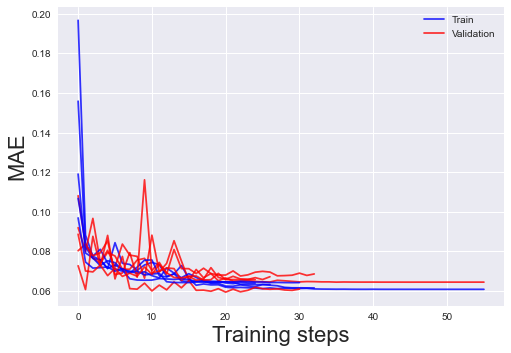

<IPython.core.display.Javascript object>

In [318]:
summarize_diagnostics(histories)
plt.rcParams["font.size"] = 22


In [319]:
# converting list to array
yh = np.array(all_preds)
yh.shape

(5, 2928, 1)

<IPython.core.display.Javascript object>

In [320]:
Pr_test = power_r[int(n * splt_2) :]
# Pr_train = power_r[: int(n * splt_1)]
# Pr_val = power_r[int(n * splt_1) : int(n * splt_2)]


yh0 = np.multiply(yh[0, :, :], Pr_test)
yh1 = np.multiply(yh[1, :, :], Pr_test)
yh2 = np.multiply(yh[2, :, :], Pr_test)
yh3 = np.multiply(yh[3, :, :], Pr_test)
yh4 = np.multiply(yh[4, :, :], Pr_test)
# yh5 = np.multiply(yhat5, Pr_test)
# yh6 = np.multiply(yhat6, Pr_test)
# yh7 = np.multiply(yhat7, Pr_test)
# yh8 = np.multiply(yhat8, Pr_test)
# yh9 = np.multiply(yhat9, Pr_test)


P_test = y[int(n * splt_2) :]
# P_train = y[: int(n * splt_1)]
# P_val = y[int(n * splt_1) : int(n * splt_2)]

yhat0 = pd.DataFrame(yh0)
yhat1 = pd.DataFrame(yh1)
yhat2 = pd.DataFrame(yh2)
yhat3 = pd.DataFrame(yh3)
yhat4 = pd.DataFrame(yh4)
# yhat5 = pd.DataFrame(yh5)
# yhat6 = pd.DataFrame(yh6)
# yhat7 = pd.DataFrame(yh7)
# yhat8 = pd.DataFrame(yh8)
# yhat9 = pd.DataFrame(yh9)

yhat = (yhat0 + yhat1 + yhat2 + yhat3 + yhat4) / 5
# result = pd.DataFrame(pd.concat([yhat0, yhat1, yhat2, yhat3, yhat4], axis=1))
# result = result.to_numpy(dtype="float", na_value=np.nan)
# yhat = pd.DataFrame(np.median(result, axis=1))


yhat[yhat > Pr_test] = Pr_test
yhat[yhat < 0] = 0
exp

5

<IPython.core.display.Javascript object>

In [321]:
# ytrain[ytrain > Pr_train] = Pr_train
# ytrain[ytrain < 0] = 0

# yval[yval > Pr_val] = Pr_val
# yval[yval < 0] = 0


# ytrain.to_csv(
#     output + "CNN_GFS_Train_U_" + str(exp) + "_2020.csv",
#     float_format="%.2f",
#     index=False,
# )

# yval.to_csv(
#     output + "CNN_GFS_Val_U_" + str(exp) + "_2020.csv", float_format="%.2f", index=False
# )
output = "O:\TU_Dell_03March_2021\Belgian_gfs_Forecast\DL_Model_exp4\outputs\\"

yhat_ens = pd.concat([yhat0, yhat1, yhat2, yhat3, yhat4], axis=1)

yhat_ens.to_csv(
    output + "MLP_ERA5_Test_U_R1_Ens" + str(exp) + "_2020.csv",
    float_format="%.2f",
    index=False,
)


yhat.to_csv(
    output + "MLP_ERA5_Test_U_R1_" + str(exp) + "_2020.csv",
    float_format="%.2f",
    index=False,
)

<IPython.core.display.Javascript object>

In [322]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score


[
    mean_absolute_error(P_test, yhat0),
    mean_absolute_error(P_test, yhat1),
    mean_absolute_error(P_test, yhat2),
    mean_absolute_error(P_test, yhat3),
    mean_absolute_error(P_test, yhat4),
    #     mean_absolute_error(P_test, yhat5),
    #     mean_absolute_error(P_test, yhat6),
    #     mean_absolute_error(P_test, yhat7),
    #     mean_absolute_error(P_test, yhat8),
    #     mean_absolute_error(P_test, yhat9),
]

[109.4134253638585,
 107.85470338114295,
 106.28408025997541,
 105.18219132682269,
 107.50677661352505]

<IPython.core.display.Javascript object>

In [323]:
[
    mean_absolute_error(P_test, yhat),
    mean_squared_error(P_test, yhat, squared=False),
    mean_absolute_percentage_error(P_test, yhat),
    r2_score(P_test, yhat),
]


[105.50974912522474, 161.8212875203061, 1232129442062028.5, 0.9344709964818343]

<IPython.core.display.Javascript object>

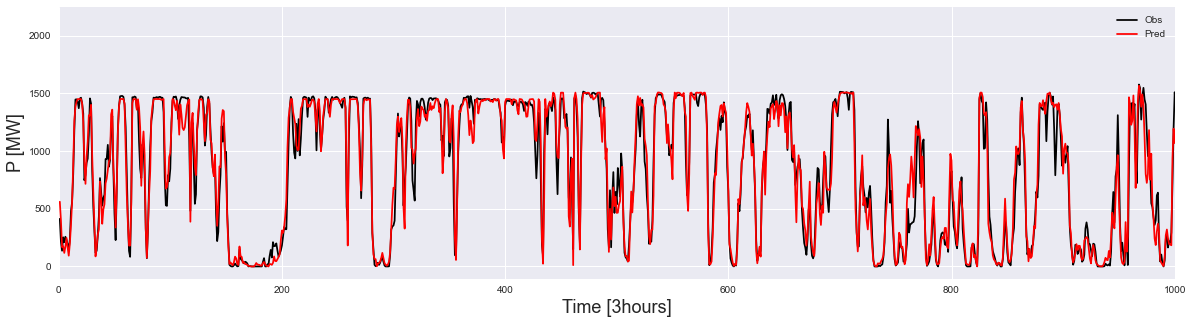

<IPython.core.display.Javascript object>

In [303]:
epochs = range(1, len(yhat) + 1)

plt.figure(figsize=(20, 5))
plt.rcParams.update({"font.size": 22})
plt.plot(epochs, np.squeeze(P_test), "black", label="Obs")
# plt.plot(dataframe, "green", label="Naive")
plt.plot(epochs, np.squeeze(yhat), "red", label="Pred")
plt.xlim(0, 1000)


# plt.plot(epochs, np.abs(DataFrame(power_test["nowcast_3hr"])), "blue", label="Nowcast")
# plt.plot(epochs, np.abs(DataFrame(power_test["dayahead_3hr"])), "pink", label="Dayahead")


plt.xlabel("Time [3hours]", fontsize=18)
plt.ylabel("P [MW]", fontsize=18)
# plt.title("Training and validation loss")
plt.legend()

# LSTM Architecture 

In [ ]:
def split_series(series, y_series, n_past, n_future):
    #
    # n_past ==> no of past observations
    #
    # n_future ==> no of future observations
    #
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = (
            series[window_start:past_end, :],
            y_series[past_end:future_end, :],
        )
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)



In [ ]:
x = np.concatenate(
    (Ut, power_r),
    axis=1,
)

# x[:, :3]

In [ ]:
n_past = 3
n_future = 1

train_Xx, train_yy = split_series(x,y, n_past, n_future)

[train_Xx.shape, train_yy.shape]



In [ ]:
splt_1 = 0.8
splt_2 = 0.9

n_train = int(splt_1 * len(train_Xx))
n_val = int(splt_2 * len(train_Xx))

X_train_LSTM, y_train_LSTM = train_Xx[:n_train, :], train_yy[:n_train, :]
X_val_LSTM, y_val_LSTM = train_Xx[n_train:n_val], train_yy[n_train:n_val]
X_test_LSTM, y_test_LSTM = train_Xx[n_val:, :], train_yy[n_val:, :]

[
    X_train_LSTM.shape,
    y_train_LSTM.shape,
    X_val_LSTM.shape,
    y_val_LSTM.shape,
    X_test_LSTM.shape,
    y_test_LSTM.shape,
]
# np.rint(y_val_LSTM)

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Bidirectional
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras import backend as K
from keras import layers, models, optimizers
from tensorflow.keras.models import Model


seed(1)


tensorflow.random.set_seed(1)

lstm_input = Input(shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2]))
# lstm units
hidden1 = Bidirectional(LSTM(256))(lstm_input)
# hidden11 = Bidirectional(LSTM(256))(hidden1)
hidden2 = Dense(128, activation="relu", kernel_initializer="he_uniform")(hidden1)
hidden3 = Dense(128, activation="relu", kernel_initializer="he_uniform")(hidden2)
hidden4 = Dense(256, activation="relu", kernel_initializer="he_uniform")(hidden3)
hidden5 = Dense(512, activation="relu", kernel_initializer="he_uniform")(hidden4)
hidden6 = layers.Dropout(0.4)(hidden5)
lstm_output = Dense(1)(hidden5)
model_lstm = Model(inputs=[lstm_input], outputs=lstm_output)


model_lstm.compile(loss="mae", optimizer=optimizers.Adam(lr=0.001))

In [ ]:
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

# OUTPUT_DIR  = os.path.join(PATH,"bcheneka" )
StrOut = "History_mlp_lstm.csv"
csv_logger = CSVLogger(StrOut, append=False, separator=";")

STR = "mlp_lstm.hdf5"

F = STR
ch = ModelCheckpoint(F, monitor="val_loss", save_best_only=True, mode="min", verbose=0)
es = EarlyStopping(monitor="val_loss", mode="min", patience=40, verbose=0)



In [ ]:
callbacks_list = [ch, es, csv_logger]

epochs = 2000
batch_size = 256


history = model_lstm.fit(
    x=[X_train_LSTM],
    y=y_train_LSTM,
    validation_data=([X_val_LSTM], y_val_LSTM),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks_list,
    verbose=1,
)

In [ ]:
# plot history
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.legend()
plt.show()

In [ ]:
model_lstm.load_weights("mlp_lstm.hdf5")
yhat = model_lstm.predict([X_test_LSTM])

In [ ]:
epochs = range(1, len(y_test_LSTM) + 1)

plt.figure(figsize=(20, 5))
plt.plot(epochs, np.squeeze(y_test_LSTM), "black", label="Obs")
# plt.plot(dataframe, "green", label="Naive")
plt.plot(epochs, yhat, "red", label="Pred")


# plt.plot(epochs, np.abs(DataFrame(power_test["nowcast_3hr"])), "blue", label="Nowcast")
# plt.plot(epochs, np.abs(DataFrame(power_test["dayahead_3hr"])), "pink", label="Dayahead")


plt.xlabel("Time [3hours]", fontsize=18)
plt.ylabel("P [MW]", fontsize=18)
# plt.title("Training and validation loss")
plt.legend()

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score


[
    mean_absolute_error(np.squeeze(y_test_LSTM), yhat),
    mean_squared_error(np.squeeze(y_test_LSTM), yhat, squared=False),
    mean_absolute_percentage_error(np.squeeze(y_test_LSTM), yhat),
    r2_score(np.squeeze(y_test_LSTM), yhat),
]

# MLP-LSTM

In [ ]:
from keras.layers import Input, Dense, concatenate
import pydot

seed(1)


tensorflow.random.set_seed(1)

con_out = concatenate([mlp_out, lstm_output])
hh1 = Dense(32, activation="relu", kernel_initializer="he_uniform")(con_out)

hdrop1 = Dropout(0.1)(hh1)

hh2 = Dense(16, activation="relu", kernel_initializer="he_uniform")(hdrop1)
hdrop = Dropout(0.2)(hh2)

f_m = Dense(1)(con_out)
model_mlp_lstm = Model(inputs=[mlp_input, lstm_input], outputs=f_m)

plot_model(
    model_mlp_lstm, to_file="model_plot.png", show_shapes=True, show_layer_names=True
)

In [ ]:
model_mlp_lstm.compile(loss="mae", optimizer=optimizers.Adam(lr=0.001))  #
model_mlp_lstm.summary()

In [ ]:
[train_X.shape, X_train_LSTM.shape, train_y.shape]

In [ ]:
callbacks_list = [ch, es, csv_logger]

epochs = 2000
batch_size = 128


history = model_mlp_lstm.fit(
    x=[train_X, X_train_LSTM],
    y=train_y,
    validation_data=([val_X, X_val_LSTM], val_y),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks_list,
    verbose=1,
)

In [ ]:
# plot history
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.legend()
plt.show()

In [ ]:
# model_mlp_lstm.load_weights("mlp_lstm.hdf5")
yhat = model_mlp_lstm.predict([X_test, X_test_LSTM])

In [ ]:
epochs = range(1, len(y_test_LSTM) + 1)

plt.figure(figsize=(20, 5))
plt.plot(epochs, np.squeeze(y_test_LSTM), "black", label="Obs")
# plt.plot(dataframe, "green", label="Naive")
plt.plot(epochs, yhat, "red", label="Pred")


# plt.plot(epochs, np.abs(DataFrame(power_test["nowcast_3hr"])), "blue", label="Nowcast")
# plt.plot(epochs, np.abs(DataFrame(power_test["dayahead_3hr"])), "pink", label="Dayahead")


plt.xlabel("Time [3hours]", fontsize=18)
plt.ylabel("P [MW]", fontsize=18)
# plt.title("Training and validation loss")
plt.legend()

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score


[
    mean_absolute_error(y_test, yhat),
    mean_squared_error(y_test, yhat, squared=False),
    mean_absolute_percentage_error(y_test, yhat),
    r2_score(y_test, yhat),
]

# CNN 1D

In [ ]:
inputs = Input(shape=(train_X.shape[1], 1))
cnv_1 = layers.SeparableConv1D(16, 2, activation="relu", padding="same")(inputs)
cnv_2 = layers.BatchNormalization()(cnv_1)
cnv_3 = layers.AveragePooling1D(2)(cnv_2)
cnv_4 = layers.SeparableConv1D(32, 2, activation="relu", padding="same")(cnv_3)
cnv_5 = layers.BatchNormalization()(cnv_4)
cnv_6 = layers.AveragePooling1D(2)(cnv_5)
cnv_7 = layers.Flatten()(cnv_6)
cnv_8 = layers.Dense(16, activation="relu")(cnv_7)
cnv_9 = layers.Dense(32, activation="relu")(cnv_8)
# ccn  =layers.Dropout(0.35)(cnv_7)
cnv_10 = layers.Dense(64, activation="relu")(cnv_9)
cnv_out = layers.Dense(1)(cnv_10)


cnv_mdl = Model(inputs=inputs, outputs=cnv_out)

cnv_mdl.compile(loss="mae", optimizer=optimizers.Adam(lr=0.001))  #

# plot_model(model_t, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
cnv_mdl.summary()

In [ ]:
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

# OUTPUT_DIR  = os.path.join(PATH,"bcheneka" )
StrOut = "cnv.csv"
csv_logger = CSVLogger(StrOut, append=False, separator=";")

STR = "cnv.hdf5"

F = STR
ch = ModelCheckpoint(F, monitor="val_loss", save_best_only=True, mode="min", verbose=0)
es = EarlyStopping(monitor="val_loss", mode="min", patience=40, verbose=0)



In [ ]:
callbacks_list = [ch, es, csv_logger]

epochs = 2000
batch_size = 128


history = cnv_mdl.fit(
    x=[train_X],
    y=train_y,
    validation_data=([val_X], val_y),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks_list,
    verbose=1,
)

In [ ]:
# plot history
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.legend()
plt.show()

In [ ]:
cnv_mdl.load_weights("cnv.hdf5")
yhat = cnv_mdl.predict(X_test)
yhat.shape

In [ ]:
epochs = range(1, len(yhat) + 1)

plt.figure(figsize=(20, 5))
plt.plot(epochs, np.squeeze(y_test_LSTM), "black", label="Obs")
# plt.plot(dataframe, "green", label="Naive")
plt.plot(epochs, np.squeeze(yhat), "red", label="Pred")


# plt.plot(epochs, np.abs(DataFrame(power_test["nowcast_3hr"])), "blue", label="Nowcast")
# plt.plot(epochs, np.abs(DataFrame(power_test["dayahead_3hr"])), "pink", label="Dayahead")


plt.xlabel("Time [3hours]", fontsize=18)
plt.ylabel("P [MW]", fontsize=18)
# plt.title("Training and validation loss")
plt.legend()

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score


[
    mean_absolute_error(y_test, yhat),
    mean_squared_error(y_test, yhat, squared=False),
    mean_absolute_percentage_error(y_test, yhat),
    r2_score(y_test, yhat),
]

# MLP-CNN-LSTM

In [ ]:
from keras.layers import Input, Dense, concatenate
import pydot

cnn_mlp_lstm = concatenate([mlp_out, cnv_10, lstm_output])
hh1 = Dense(32, activation="relu", kernel_initializer="he_uniform")(cnn_mlp_lstm)

hdrop1 = Dropout(0.1)(hh1)

hh2 = Dense(16, activation="relu", kernel_initializer="he_uniform")(hdrop1)
hdrop = Dropout(0.2)(hh2)

f_m = Dense(1)(cnn_mlp_lstm)
model_mlp_cnn_lstm = Model(inputs=[mlp_input, inputs, lstm_input], outputs=f_m)

plot_model(
    model_mlp_cnn_lstm,
    to_file="model_plot.png",
    show_shapes=True,
    show_layer_names=True,
)
model_mlp_cnn_lstm.compile(loss="mae", optimizer=optimizers.Adam(lr=0.0001))  #
model_mlp_cnn_lstm.summary()

In [ ]:
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

# OUTPUT_DIR  = os.path.join(PATH,"bcheneka" )
StrOut = "History_mlp_cnn_lstm.csv"
csv_logger = CSVLogger(StrOut, append=False, separator=";")

STR = "mlp_cnn_lstm.hdf5"

F = STR
ch = ModelCheckpoint(F, monitor="val_loss", save_best_only=True, mode="min", verbose=0)
es = EarlyStopping(monitor="val_loss", mode="min", patience=40, verbose=0)



In [ ]:
callbacks_list = [ch, es, csv_logger]

epochs = 2000
batch_size = 128


history = model_mlp_cnn_lstm.fit(
    x=[train_X, train_X, X_train_LSTM],
    y=train_y,
    validation_data=([val_X, val_X, X_val_LSTM], val_y),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks_list,
    verbose=1,
)

In [ ]:
# plot history
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.legend()
plt.show()

In [ ]:
model_mlp_cnn_lstm.load_weights("mlp_cnn_lstm.hdf5")
yhat = model_mlp_cnn_lstm.predict([X_test, X_test, X_test_LSTM])

In [ ]:
epochs = range(1, len(yhat) + 1)

plt.figure(figsize=(20, 5))
plt.plot(epochs, np.squeeze(y_test), "black", label="Obs")
# plt.plot(dataframe, "green", label="Naive")
plt.plot(epochs, yhat, "red", label="Pred")


# plt.plot(epochs, np.abs(DataFrame(power_test["nowcast_3hr"])), "blue", label="Nowcast")
# plt.plot(epochs, np.abs(DataFrame(power_test["dayahead_3hr"])), "pink", label="Dayahead")


plt.xlabel("Time [3hours]", fontsize=18)
plt.ylabel("P [MW]", fontsize=18)
# plt.title("Training and validation loss")
plt.legend()

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score


[
    mean_absolute_error(y_test, yhat),
    mean_squared_error(y_test, yhat, squared=False),
    mean_absolute_percentage_error(y_test, yhat),
    r2_score(y_test, yhat),
]

In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [("var%d(t-%d)" % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [("var%d(t)" % (j + 1)) for j in range(n_vars)]
        else:
            names += [("var%d(t+%d)" % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
# ensure all data is float
x = np.concatenate(
    (Ut, power_r, y),
    axis=1,
)

values = x.astype("float32")
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 2
n_features = 123
# frame as supervised learning
reframed = series_to_supervised(values, n_hours, 1)
# print(values.shape)
reframed.head()

In [ ]:
# split into train and test sets
values = reframed.values
splt_1 = 0.8
splt_2 = 0.9

n_train = int(splt_1 * len(values))
n_val = int(splt_2 * len(values))

train = values[:n_train, :]
val = values[n_train:n_val]
test = values[n_val:, :]
values.shape

In [ ]:
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, n_features]
val_X, val_y = val[:, :n_obs], val[:, n_features]
test_X, test_y = test[:, :n_obs], test[:, n_features]
print(train_X.shape, len(train_X), train_y.shape)


# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(
    train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape
)

np.rint(test_y)

In [ ]:
# design network
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Bidirectional
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras import backend as K
from keras import layers, models, optimizers

lstm_input = Input(shape=(train_X.shape[1], train_X.shape[2]))
# lstm units
hidden1 = (LSTM(64))(lstm_input)
hidden2 = Dense(64, activation="relu", kernel_initializer="he_uniform")(hidden1)
hidden3 = Dense(128, activation="relu", kernel_initializer="he_uniform")(hidden2)
hidden4 = Dense(256, activation="relu", kernel_initializer="he_uniform")(hidden3)
lstm_output = Dense(1)(hidden4)
model_lstm = Model(inputs=[lstm_input], outputs=lstm_output)


# model = Sequential()
# model.add((LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2]))))
# model.add(Dense(64))
# model.add(Dense(32))
# model.add(Dense(1))
model_lstm.compile(loss="mae", optimizer=optimizers.Adam(lr=0.0001))

In [ ]:
from keras.layers import Input, Dense, concatenate
import pydot

con_out = concatenate([mlp_out, lstm_output])
hh1 = Dense(32, activation="relu", kernel_initializer="he_uniform")(con_out)

hdrop1 = Dropout(0.1)(hh1)

hh2 = Dense(16, activation="relu", kernel_initializer="he_uniform")(hdrop1)
hdrop = Dropout(0.2)(hh2)

f_m = Dense(1)(con_out)
model_mlp_lstm = Model(inputs=[mlp_input, lstm_input], outputs=f_m)

plot_model(
    model_mlp_lstm, to_file="model_plot.png", show_shapes=True, show_layer_names=True
)

In [ ]:
model_mlp_lstm.compile(loss="mae", optimizer=optimizers.Adam(lr=0.0001))  #
model_mlp_lstm.summary()

In [ ]:
[train_X.shape, train_X_l.shape, val_X.shape, val_X_l.shape]

In [ ]:
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

# OUTPUT_DIR  = os.path.join(PATH,"bcheneka" )
StrOut = "History_mlp_lstm.csv"
csv_logger = CSVLogger(StrOut, append=False, separator=";")

STR = "mlp_lstm.hdf5"

F = STR
ch = ModelCheckpoint(F, monitor="val_loss", save_best_only=True, mode="min", verbose=0)
es = EarlyStopping(monitor="val_loss", mode="min", patience=40, verbose=0)



In [ ]:
callbacks_list = [ch, es, csv_logger]

epochs = 2000
batch_size = 256


history = model_mlp_lstm.fit(
    x=[train_X_l, train_X],
    y=train_y,
    validation_data=([val_X_l, val_X], val_y),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks_list,
    verbose=1,
)

In [ ]:
# make a prediction


model_mlp_lstm.load_weights("mlp_lstm.hdf5")
yhat = model_mlp_lstm.predict([test_X_l, test_X])
yhat_train = model_mlp_lstm.predict([train_X_l, train_X])
yhat_val = model_mlp_lstm.predict([val_X_l, val_X])

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

[
    sqrt(mean_squared_error(train_y, yhat_train)),
    sqrt(mean_squared_error(val_y, yhat_val)),
    sqrt(mean_squared_error(test_y, yhat)),
]

In [ ]:
epochs = range(1, len(test_y) + 1)

plt.figure(figsize=(20, 5))
plt.plot(epochs, test_y, "black", label="Obs")
# plt.plot(dataframe, "green", label="Naive")
plt.plot(epochs, yhat, "red", label="Pred")


# plt.plot(epochs, np.abs(DataFrame(power_test["nowcast_3hr"])), "blue", label="Nowcast")
# plt.plot(epochs, np.abs(DataFrame(power_test["dayahead_3hr"])), "pink", label="Dayahead")


plt.xlabel("Time [3hours]", fontsize=18)
plt.ylabel("P [MW]", fontsize=18)
# plt.title("Training and validation loss")
plt.legend()

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score


[
    mean_absolute_error(test_y, yhat),
    mean_squared_error(test_y, yhat, squared=False),
    mean_absolute_percentage_error(test_y, yhat),
    r2_score(test_y, yhat),
]

In [ ]:
[
    mean_absolute_error(val_y, yhat_val),
    mean_squared_error(val_y, yhat_val, squared=False),
    mean_absolute_percentage_error(val_y, yhat_val),
    r2_score(val_y, yhat_val),
]

In [ ]:
[
    mean_absolute_error(train_y, yhat_train),
    mean_squared_error(train_y, yhat_train, squared=False),
    mean_absolute_percentage_error(train_y, yhat_train),
    r2_score(train_y, yhat_train),
]

In [ ]:
import pandas as pd
from pathlib import Path
import os
from os.path import isfile, join
from datetime import date
import csv
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#assign working directory to variable
file_path=os.getcwd()
#setting path for data folder
DATA_PATH = Path.cwd().parent /"Belgian_power_3hr"
print(DATA_PATH)


In [ ]:
power = pd.read_csv(DATA_PATH / "Belgian_power_2016_2017_3hrly.csv")

In [ ]:
power["TIMESTAMP"] = pd.to_datetime(power["TIMESTAMP"])

In [ ]:
date_from = pd.Timestamp(date(2016,1,1))
date_to = pd.Timestamp(date(2018,1,1))


In [ ]:
# df is defined in the previous example

power = power[(power["TIMESTAMP"] >= date_from) & (power["TIMESTAMP"] <= date_to)]

# power[240 : len(power)]
y = power["Obs_3hr"].values.reshape(len(power), 1)
mask = np.isnan(y)
y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])
# y = y[:2928]
# y.shape
power.shape

In [ ]:
splt_1 = 0.8
splt_2 = 0.9

n = len(y)
y_train = y[0 : int(n * splt_1)]
y_val = y[int(n * splt_1) : int(n * splt_2)]
y_test = y[int(n * splt_2) :]

y_train_Ens = y[0 : int(n * splt_2)]

[y_train.shape, y_val.shape]

power_test = power[int(n * splt_2) :]
power_test.head()


In [ ]:
from prophet import Prophet

In [ ]:
from netCDF4 import Dataset

fn = "/home/bcheneka/data_climate/ramp_forecasts/gfs_4_2016_2017.nc"
ds = Dataset(fn, mode="r")

lons = ds.variables["lon"][:]
lats = ds.variables["lat"][:]
U = ds.variables["U"]
[U.shape, lons.shape, lats.shape]

In [ ]:
import nctoolkit as nc

lat_bnds, lon_bnds = [50.5, 54], [0, 5]

lat_inds = np.where((lats > lat_bnds[0]) & (lats < lat_bnds[1]))[0]
lon_inds = np.where((lons > lon_bnds[0]) & (lons < lon_bnds[1]))[0]

U = np.squeeze(ds.variables["U"][:, :, lat_inds, lon_inds])


lats.shape

In [ ]:
x = U.reshape(len(U), U.shape[1], U.shape[2], 1)
# X_test = x[224:248]
# X = x[0:224]

X_train = x[0 : int(n * splt_1)]
X_val = x[int(n * splt_1) : int(n * splt_2)]
X_test = x[int(n * splt_2) :]

X_train_Ens = x[0 : int(n * splt_2)]


np.squeeze(X_train[1, :, :]).shape
[X_train.shape, X_val.shape]

In [ ]:
import os
import matplotlib.pyplot as plt
from netCDF4 import Dataset as netcdf_dataset
import numpy as np

from cartopy import config
import cartopy.crs as ccrs


dataset = netcdf_dataset(fn)
sst = np.squeeze(dataset.variables["U"][0, :, :])
lats = dataset.variables["lat"][:]
lons = dataset.variables["lon"][:]
sst.shape

In [ ]:
cmsize = [15, 10]
dpi_display = 96  # DPI of your screen
fig = plt.figure(figsize=[x / 2.54 for x in cmsize], dpi=dpi_display)
ax = plt.axes(projection=ccrs.PlateCarree())

plot = plt.contourf(
    lons[lon_inds],
    lats[lat_inds],
    np.squeeze(U[1, :, :]),
    60,
    transform=ccrs.PlateCarree(),
)

# Add a colorbar for the filled contour.
# add colorbar
axpos = ax.get_position()
# add colorbar
axpos = ax.get_position()
cbar_ax = fig.add_axes([axpos.x1 + 0.02, axpos.y0, 0.03, axpos.height])
cbar = fig.colorbar(plot, cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)
cbar.set_label("U (m/s)", fontsize=12)

# cbar_ax = plt.add_axes([axpos.x1 + 0, axpos.y0, 0.03, axpos.height])
# cbar = plt.colorbar(orientation="horizontal")
# cbar.set_label("U(m/s)", fontsize=12)
ax.coastlines()

plt.show()

# CNN

In [ ]:
WIDTH = X_train.shape[1] #U.shape[1]
HEIGHT = X_train.shape[2] #U.shape[2]

from keras import layers, models, optimizers
from keras.utils.vis_utils import plot_model
from keras import metrics
import pydot

from numpy.random import seed

seed(1)


import tensorflow

tensorflow.random.set_seed(1)

from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.models import Model


from keras import layers, models, optimizers
from keras import metrics
from keras.layers import Input, Dense, Flatten, Reshape, Dropout, SpatialDropout1D
from keras.layers.merge import average




# inputs = Input(shape = (X_train.shape[1],X_train.shape[2],1))
# cnv_1 = layers.SeparableConv2D(16, 2, activation = 'relu', padding = "same")(inputs)
# cnv_2 = layers.BatchNormalization()(cnv_1)
# cnv_3 = layers.AveragePooling2D(2)(cnv_2)
# cnv_4 = layers.SeparableConv2D(32, 2, activation = 'relu', padding = "same")(cnv_3)
# cnv_5 = layers.BatchNormalization()(cnv_4)
# cnv_6 = layers.AveragePooling2D(2)(cnv_5)
# cnv_7 = layers.Flatten()(cnv_6)
# cnv_8 = layers.Dense(16, activation = 'relu')(cnv_7)
# cnv_9 = layers.Dense(32, activation = 'relu')(cnv_8)
# cnv_10 = layers.Dense(64, activation = 'relu')(cnv_9)
# cnv_out = layers.Dense(1, activation = 'relu')(cnv_10)



# cnv_mdl = Model(inputs = inputs, outputs = cnv_out)

# cnv_mdl.summary()

#plot_model(model_t, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


# MLP

In [ ]:
power_r = power["rated_3hr"].values.reshape(power.shape[0], 1)

mask = np.isnan(power_r)
power_r[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), power_r[~mask])


mask = np.isnan(y)
y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])


mask = np.isnan(power_r)
power_r[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), power_r[~mask])


In [ ]:
def daterange(start_date, end_date):
    delta = timedelta(hours=3)
    while start_date < end_date:
        yield start_date
        start_date += delta


from datetime import datetime, timedelta

start_date = datetime(2016, 1, 1, 00, 00)
end_date = datetime(2016, 12, 31, 23, 00)

timestamp_g = []

for single_date in daterange(start_date, end_date):
    tas = single_date.strftime("%Y-%m-%d %H:%M:%S")
    timestamp_g.append(tas)


from pandas import DataFrame

times = DataFrame(timestamp_g, columns=["Times"])
times.head()


import datetime


times["Times"] = pd.to_datetime(times["Times"])
timestamp_s = power["TIMESTAMP"].map(datetime.datetime.timestamp)


day = 3 * 60 * 60
year = (365.2425) * day

power["Day sin"] = np.sin(timestamp_s * (2 * np.pi / day))
power["Day cos"] = np.cos(timestamp_s * (2 * np.pi / day))
power["Year sin"] = np.sin(timestamp_s * (2 * np.pi / year))
power["Year cos"] = np.cos(timestamp_s * (2 * np.pi / year))
# power["Day sin"]

Ys = power["Year sin"]
Ys.shape
# power["Year cos"].reshape(power["Year cos"], power["Year cos"][0], 1) ,
#       power["Year sin"].values.reshape(power.shape[0], 1),
#      power["Year cos"].values.reshape(power.shape[0], 1),
power_r.min()

# MLP Predictors

In [ ]:
# import matlab.engine

# eng = matlab.engine.start_matlab()

In [ ]:
Up = np.squeeze(ds.variables["U"])

Up.shape

In [ ]:
# y_p = y[0 : int(n * splt_1)]
# X_p = Up[0 : int(n * splt_1)]
# y_p = matlab.double(y_p.tolist())
# X_p = matlab.double(X_p.tolist())
# lon = matlab.double(lons.tolist())
# lat = matlab.double(lats.tolist())


fn = "/home/bcheneka/data_climate/ramp_forecasts/U_2016_2017_predictor_gfs.nc"
ds = Dataset(fn, mode="r")

# lons = ds.variables["lon"][:]
# lats = ds.variables["lat"][:]
Us = ds.variables["U_2016"]
Ut = np.transpose(Us)

In [ ]:
# Ut = U.reshape(len(U), U.shape[1] * U.shape[2])
Ut.shape

In [ ]:
# U = U.reshape(U.shape[0], U.shape[1] * U.shape[2])
U.shape

In [ ]:
x = np.concatenate(
    (Ut, power_r),
    axis=1,
)
n = len(x)
# X_trainl = x[0 : int(n * splt_1)]

# X_vall = x[int(n * splt_1) : int(n * splt_2)]


X_testl = x[int(n * splt_2) :]

X_trainl_Ens = x[0 : int(n * splt_2)]
y_train_Ens = y[0 : int(n * splt_2)]

[X_trainl_Ens.shape, y_train_Ens.shape]

In [ ]:
# https://stackoverflow.com/questions/29438265/stratified-train-test-split-in-scikit-learn

from sklearn.model_selection import train_test_split

# 5 bins may be too few for larger datasets.
bins = np.linspace(start=np.amin(y_train_Ens), stop=np.amax(y_train_Ens), num=60)

y_binned = np.digitize(y_train_Ens, bins, right=True)

X_trainl, X_vall, y_train, y_val = train_test_split(
    X_trainl_Ens, y_train_Ens, test_size=0.10, stratify=y_binned
)
[X_trainl.shape, X_vall.shape, y_train.shape, y_val.shape]


In [ ]:
mlp_input = Input(shape=X_trainl.shape[1])

hidden1 = Dense(32, activation="relu", kernel_initializer="he_uniform")(mlp_input)
hidden2 = Dense(32, activation="relu", kernel_initializer="he_uniform")(hidden1)
hidden3 = Dense(64, activation="relu", kernel_initializer="he_uniform")(hidden2)
hidden4 = Dense(128, activation="relu", kernel_initializer="he_uniform")(hidden3)
# hidden5 = layers.Dropout(0.05)(hidden4)
hidden6 = Dense(256, activation="relu", kernel_initializer="he_uniform")(hidden4)
hidden7 = layers.Dropout(0.3)(hidden6)
hidden8 = Dense(32, activation="relu", kernel_initializer="he_uniform")(hidden7)


mlp_out = Dense(1)(hidden8)
model_ap = Model(inputs=mlp_input, outputs=mlp_out)
model_ap.summary()

#  MLP

In [ ]:
# con_out = average([mlp_out, cnv_out])
# con_cnn_mlp = Model(inputs=[inputs, mlp_input], outputs=con_out)
# plot_model(con_cnn_mlp, to_file="model.png", show_shapes=True, show_layer_names=True)

In [ ]:
epochs = 30


learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
sgd = optimizers.SGD(
    lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False
)
model_ap.compile(loss="mae", optimizer=optimizers.Adam(lr=0.0001))
# con_cnn_mlp.compile( loss="mae", optimizer=optimizers.Adam(
#        lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0 ),)
# optimizer=sgd)  # optimizers.SGD(lr=0.001))
model_ap.summary()

In [ ]:
# def train(x):
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation

from tensorflow.keras.callbacks import LearningRateScheduler
import math

from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

import os

# import os

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import ModelCheckpoint

# os.environ["MK_NUM_THREADS"] = "20"
# os.environ["GOTO_NUM_THREADS"] = "20"
# os.environ["OMP_NUM_THREADS"] = "20"
# os.environ["openmp"] = "True"


# tf.config.threading.set_intra_op_parallelism_threads(20)


# model_best = tuner.get_best_models(num_models=1)[0]

config = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=20,
    inter_op_parallelism_threads=20,
    allow_soft_placement=True,
)
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

# OUTPUT_DIR  = os.path.join(PATH,"bcheneka" )
StrOut = "History_mlp.csv"
csv_logger = CSVLogger(StrOut, append=False, separator=";")

STR = "mlp.hdf5"

F = STR
ch = ModelCheckpoint(F, monitor="val_loss", save_best_only=True, mode="min", verbose=0)
es = EarlyStopping(monitor="val_loss", mode="min", patience=40, verbose=0)

import keras

# define step decay function
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get("loss"))
        self.lr.append(step_decay(len(self.losses)))
        print("lr:", step_decay(len(self.losses)))


def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.1
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop, math.floor((epoch) / epochs_drop))
    return lrate


# learning schedule callback
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay)


callbacks_list = [ch, es, csv_logger]

epochs = 1000

nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)

batch_size = 128


history = model_ap.fit(
    x=[X_trainl],
    y=y_train,
    validation_data=([X_vall], y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks_list,
    verbose=1,
)
# K.clear_session()
# tf.compat.v1.reset_default_graph()
# tf.keras.backend.clear_session()

# print(OUTPUT_DIR)

In [ ]:
[X_trainl.shape, X_vall.shape]

In [ ]:
# # acc = history.history['loss']
# # val_acc = history.history['val_mean_squared_error']
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
# # plt.plot(epochs, acc, 'blue', label='Training acc')
# # plt.plot(epochs, val_acc, 'red', label='Validation acc')
# # plt.title('Training and validation accuracy')
# # plt.legend()
plt.figure()
plt.plot(epochs, loss, "blue", label="Training loss")
plt.plot(epochs, val_loss, "red", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.savefig("mlp_learning_curve.png", bbox_inches="tight")
# , y_train.size, val.size(), y_val.size()]

In [ ]:
[X_train.shape, X_trainl.shape, X_val.shape, X_vall.shape, X_testl.shape]
[
    y_train.shape,
    y_val.shape,
]

In [ ]:
model_ap.load_weights("mlp.hdf5")
# batch_size = 1
# # # model.summary
predTr = model_ap.predict([X_trainl])
predVl = model_ap.predict([X_vall])
predx = model_ap.predict([X_testl])

Ptr = pd.DataFrame(predTr)
Pvl = pd.DataFrame(predVl)
Pts = pd.DataFrame(predx)


Ptr.to_csv("Training_pred_MLP.csv", float_format="%.2f", index=False)
Pvl.to_csv("Validation_pred_MLP.csv", float_format="%.2f", index=False)
Pts.to_csv("Testing_pred_MLP.csv", float_format="%.2f", index=False)



In [ ]:
epochs = range(1, len(predx) + 1)
# naive_len = range(1, len(naive_forecast) + 1)
# # plt.plot(epochs, acc, 'blue', label='Training acc')
# # plt.plot(epochs, val_acc, 'red', label='Validation acc')
# # plt.title('Training and validation accuracy')
# # plt.legend()
values = DataFrame(y_test)
dataframe = np.concatenate([values.shift(1)], axis=1)


plt.figure(figsize=(20, 5))
plt.plot(epochs, y_test, "black", label="Obs")
# plt.plot(dataframe, "green", label="Naive")
plt.plot(epochs, predx, "red", label="Pred")


# plt.plot(epochs, np.abs(DataFrame(power_test["nowcast_3hr"])), "blue", label="Nowcast")
# plt.plot(epochs, np.abs(DataFrame(power_test["dayahead_3hr"])), "pink", label="Dayahead")


plt.xlabel("Time [3hours]", fontsize=18)
plt.ylabel("P [MW]", fontsize=18)
# plt.title("Training and validation loss")
plt.legend()

In [ ]:
from pandas import DataFrame
from pandas import concat


values = DataFrame(y_test)
dataframe = concat([values.shift(1)], axis=1)
dataframe.columns = ["t-1"]
# print(dataframe.head(5))
# dataframe.values[0]

values = DataFrame(y_test)
dataframe_2 = concat([values.shift(2)], axis=1)

# Error
Err_naive_1 = [(np.abs(dataframe - y_test)).mean()]
Err_naive_2 = [(np.abs(dataframe_2 - y_test)).mean()]

Err_predT = [(np.abs(DataFrame(predTr) - y_train)).mean()]
Err_predV = [(np.abs(DataFrame(predVl) - y_val)).mean()]
Err_pred = [(np.abs(DataFrame(predx) - y_test)).mean()]


Err_nowcast = [(np.abs(DataFrame(power_test["nowcast_3hr"]) - y_test)).mean()]
Err_dayahead = [(np.abs(DataFrame(power_test["dayahead_3hr"]) - y_test)).mean()]


[Err_naive_1, Err_naive_2, Err_pred, Err_nowcast, Err_dayahead, Err_predT, Err_predV]
# dataframe_2.columns = ["t-1"]
# [values[:4], dataframe[:4]]



In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score


[
    mean_absolute_error(y_test, predx),
    mean_squared_error(y_test, predx, squared=False),
    mean_absolute_percentage_error(y_test, predx),
    r2_score(y_test, predx),
]

In [ ]:
[
    mean_absolute_error(y_val, predVl),
    mean_squared_error(y_val, predVl),
    mean_absolute_percentage_error(y_val, predVl),
    r2_score(y_val, predVl),
]

In [ ]:
trx = predTr.tolist()
yac = y_train.tolist()
[
    mean_absolute_error(y_train, predTr),
    mean_squared_error(y_train, predTr),
    mean_absolute_percentage_error(yac, trx),
    r2_score(y_train, predTr),
]

# Multi model

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

[X_train_Ens.shape, X_trainl.shape]

In [ ]:
# Stack generalazation
from numpy.random import seed

seed(123)


import tensorflow

tensorflow.random.set_seed(123)

epoch = 1000
from os import makedirs

# fit model on dataset
def fit_model(trainX, trainy, epochs, verbose):

    #     mlp_input = Input(shape=X_trainS.shape[1])

    #     hidden1 = Dense(32, activation="relu", kernel_initializer="he_uniform")(mlp_input)
    #     hidden2 = Dense(32, activation="relu", kernel_initializer="he_uniform")(hidden1)
    #     hidden3 = Dense(64, activation="relu", kernel_initializer="he_uniform")(hidden2)
    #     hidden4 = Dense(128, activation="relu", kernel_initializer="he_uniform")(hidden3)
    #     hidden5 = Dense(256, activation="relu", kernel_initializer="he_uniform")(hidden4)
    #     hidden6 = Dense(32, activation="relu", kernel_initializer="he_uniform")(hidden5)

    #     mlp_out = Dense(1)(hidden6)
    #     model_ap = Model(inputs=mlp_input, outputs=mlp_out)
    model_ap.compile(
        loss="mae",
        optimizer=optimizers.Adam(
            lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0
        ),
    )
    model_ap.fit(
        [X_trainl_Ens[train_index]],
        y_train_Ens[train_index],
        validation_data=(
            [X_trainl_Ens[test_index]],
            y_train_Ens[test_index],
        ),
        epochs=epoch,
        batch_size=batch_size,
        callbacks=callbacks_list,
        verbose=1,
    )
    return model_ap

In [ ]:
# kfold = KFold(n_splits=5, shuffle=False, random_state=1)

# count=1
epoch = 1000

tscv = TimeSeriesSplit(n_splits=50)
count = 1
for train_index, test_index in tscv.split(X_trainl_Ens):
    # fit model
    model_ap = fit_model(
        [X_trainl_Ens[train_index]],
        y_train_Ens[train_index],
        epochs=epoch,
        verbose=1,
    )

    # save model
    filename = "models/model_" + str(count) + ".h5"
    model_ap.save(filename)
    print(">Saved %s" % filename)
    count += 1

In [ ]:
# Create lagged dataset
# load models from file
from keras.models import load_model


def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        filename = "models/model_" + str(i + 1) + ".h5"
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print(">loaded %s" % filename)
    return all_models

In [ ]:
# load all models
n_members = 50
members = load_all_models(n_members)
print("Loaded %d models" % len(members))

In [ ]:
for model_ap in members:
    mae = model_ap.evaluate([X_testl], y_test, verbose=0)
    print("Model MAE: %.3f" % mae)

In [ ]:
model_ap.load_weights("./models/model_1.h5")
predx9 = model_ap.predict([X_testl])

model_ap.load_weights("./models/model_2.h5")
predx4 = model_ap.predict([X_testl])

epochs = range(1, len(predx4) + 1)
# # plt.plot(epochs, acc, 'blue', label='Training acc')
# # plt.plot(epochs, val_acc, 'red', label='Validation acc')
# # plt.title('Training and validation accuracy')
# # plt.legend()
plt.figure(figsize=(20, 5))
plt.plot(epochs, y_test, "black", label="Obs")
plt.plot(epochs, predx9, "blue", label="Pred")
plt.plot(epochs, predx4, "red", label="Pred")
# plt.plot(epochs, dataframe, "magenta", label="nowcast")
# plt.plot(epochs, power_test["dayahead_3hr"], "pink", label="nowcast")


plt.xlabel("Time [3hours]", fontsize=18)
plt.ylabel("P [MW]", fontsize=18)
plt.title(" ")
# plt.legend()

In [ ]:
plt.figure(figsize=(15, 5))

plt.scatter(y_test, dataframe, label = 'Persistence')
plt.scatter(y_test, predx9,label = 'Pred')



plt.xlabel("Observed [MW]", fontsize=18)
plt.ylabel("Pred [MW]", fontsize=18)
plt.xlim([0, 700])
plt.ylim([0, 700])
plt.legend()


# Concatenate MLP LSTM

In [ ]:
def split_series(series, y_series, n_past, n_future):
    #
    # n_past ==> no of past observations
    #
    # n_future ==> no of future observations
    #
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = (
            series[window_start:past_end, :],
            y_series[past_end:future_end, :],
        )
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [ ]:
y_val.shape

In [ ]:
n_past = 4
n_future = 1

train_X_LSTM, train_y_LSTM = split_series(X_trainl,y_train, n_past, n_future)

[train_X_LSTM.shape, train_y_LSTM.shape]


In [ ]:
val_X_LSTM, val_y_LSTM = split_series(X_vall, y_val, n_past, n_future)

[val_X_LSTM.shape, val_y_LSTM.shape]


In [ ]:
train_X_MLP, train_y_MLP = (
    X_trainl[n_past:, :],
    y_train[n_past:, :],
)
[train_X_MLP.shape, train_y_MLP.shape]

In [ ]:
val_X_MLP, val_y_MLP = (
    X_vall[n_past:, :],
    y_val[n_past:, :],
)
[val_X_MLP.shape, val_y_MLP.shape]

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Bidirectional
from tensorflow.keras.models import Model
from numpy.random import seed

seed(123)


import tensorflow

tensorflow.random.set_seed(123)

# lstm input shape
lstm_input = Input(shape=train_X_LSTM.shape[1:])
# lstm units
hidden1 = Bidirectional(LSTM(32))(lstm_input)
hidden2 = Dense(64)(hidden1)
hidden3 = Dense(128)(hidden2)
hidden4 = Dense(32, activation="relu")(hidden3)
# lstm output which will be predicted var1 at t=t
lstm_output = Dense(1, activation="relu")(hidden4)


# mlp input with additonal 3 variables at t=t
mlp_input = Input(shape=(train_X_MLP.shape[1]))
hidden1 = Dense(32, activation="relu", kernel_initializer="he_uniform")(mlp_input)
hidden2 = Dense(32, activation="relu", kernel_initializer="he_uniform")(hidden1)
hidden3 = Dense(64, activation="relu", kernel_initializer="he_uniform")(hidden2)
hidden4 = Dense(128, activation="relu", kernel_initializer="he_uniform")(hidden3)
hidden5 = Dense(256, activation="relu", kernel_initializer="he_uniform")(hidden4)
hidden6 = Dense(32, activation="relu", kernel_initializer="he_uniform")(hidden5)

# combine the lstm output which is predicted var1 at t=t and key in var2,var3,var4 at t=t
x = Concatenate()([lstm_output, hidden6])
# mlp model output which is predicted var1 at t=t
mlp_out = Dense(1)(x)
# final output of combined model which is predicted var1 at t=t
model = Model(inputs=[lstm_input, mlp_input], outputs=mlp_out)
# compile the model
model.compile(loss="mae", optimizer="adam")
# fit the model
# model.compile(
#     loss="mae",
#     optimizer=optimizers.Adam(
#         lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0
#     ),
# )


model.summary()

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation

from tensorflow.keras.callbacks import LearningRateScheduler
import math

from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

import os

# import os

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import ModelCheckpoint

# os.environ["MK_NUM_THREADS"] = "20"
# os.environ["GOTO_NUM_THREADS"] = "20"
# os.environ["OMP_NUM_THREADS"] = "20"
# os.environ["openmp"] = "True"


# tf.config.threading.set_intra_op_parallelism_threads(20)


# model_best = tuner.get_best_models(num_models=1)[0]

config = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=20,
    inter_op_parallelism_threads=20,
    allow_soft_placement=True,
)
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

# OUTPUT_DIR  = os.path.join(PATH,"bcheneka" )
StrOut = "History_cnn_mlp.csv"
csv_logger = CSVLogger(StrOut, append=False, separator=";")

STR = "cnn_mlp.hdf5"

F = STR
ch = ModelCheckpoint(F, monitor="val_loss", save_best_only=True, mode="min", verbose=0)
es = EarlyStopping(monitor="val_loss", mode="min", patience=40, verbose=0)

import keras

# define step decay function
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get("loss"))
        self.lr.append(step_decay(len(self.losses)))
        print("lr:", step_decay(len(self.losses)))


def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.1
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop, math.floor((epoch) / epochs_drop))
    return lrate


# learning schedule callback
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay)


callbacks_list = [ch, es, csv_logger]

epochs = 1000

nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)

batch_size = 64


history = model.fit(
    x=[train_X_LSTM, train_X_MLP],
    y=train_y_MLP,
    validation_data=([val_X_LSTM, val_X_MLP], val_y_MLP),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks_list,
    verbose=1,
)
# K.clear_session()
# tf.compat.v1.reset_default_graph()
# tf.keras.backend.clear_session()

# print(OUTPUT_DIR)


In [ ]:
[
    train_X_LSTM.shape,
    train_X_MLP.shape,
    train_y_MLP.shape,
    val_X_LSTM.shape,
    val_X_MLP.shape,
    val_y_MLP.shape,
]

In [ ]:
# # acc = history.history['loss']
# # val_acc = history.history['val_mean_squared_error']
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
# # plt.plot(epochs, acc, 'blue', label='Training acc')
# # plt.plot(epochs, val_acc, 'red', label='Validation acc')
# # plt.title('Training and validation accuracy')
# # plt.legend()
plt.figure()
plt.plot(epochs, loss, "blue", label="Training loss")
plt.plot(epochs, val_loss, "red", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.savefig("model_1_copy1_fine_stratify.png", bbox_inches="tight")
# , y_train.size, val.size(), y_val.size()]

In [ ]:
[X_train_Ens.shape, y_train_Ens.shape]

In [ ]:
test_X_LSTM, test_y_LSTM = split_series(X_testl, y_test, n_past, n_future)

[test_X_LSTM.shape, test_y_LSTM.shape]

In [ ]:
test_X_MLP, test_y_MLP = (
    X_testl[n_past:, :],
    y_test[n_past:, :],
)
[test_X_MLP.shape, test_y_MLP.shape]

In [ ]:
predx = model.predict([test_X_LSTM, test_X_MLP])
predx.shape

In [ ]:
values = DataFrame(test_y_MLP)
dataframe = concat([values.shift(1)], axis=1)
dataframe.columns = ["t-1"]
# print(dataframe.head(5))
# dataframe.values[0]

values = DataFrame(test_y_MLP)
dataframe_2 = concat([values.shift(2)], axis=1)

# Error
Err_naive_1 = [(np.abs(dataframe - test_y_MLP)).mean()]
Err_naive_2 = [(np.abs(dataframe_2 - test_y_MLP)).mean()]

Err_pred = [(np.abs(DataFrame(predx) - test_y_MLP)).mean()]

# Err_nowcast = [(np.abs(DataFrame(power_test["nowcast_3hr"]) - test_y_MLP)).mean()]
# Err_dayahead = [(np.abs(DataFrame(power_test["dayahead_3hr"]) - test_y_MLP)).mean()]


[Err_naive_1, Err_naive_2, Err_pred, Err_nowcast, Err_dayahead]

In [ ]:
epochs = range(1, len(predx) + 1)

plt.figure(figsize=(20, 5))
plt.plot(epochs, test_y_MLP, "black", label="Obs")
# plt.plot(dataframe, "green", label="Naive")
plt.plot(epochs, predx, "red", label="Pred")


# plt.plot(epochs, np.abs(DataFrame(power_test["nowcast_3hr"])), "blue", label="Nowcast")
# plt.plot(epochs, np.abs(DataFrame(power_test["dayahead_3hr"])), "pink", label="Dayahead")


plt.xlabel("Time [3hours]", fontsize=18)
plt.ylabel("P [MW]", fontsize=18)
# plt.title("Training and validation loss")
plt.legend()

# MLP-LSTM multimodel

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Bidirectional
from tensorflow.keras.models import Model
from numpy.random import seed

seed(123)


import tensorflow

tensorflow.random.set_seed(123)

# lstm input shape
lstm_input = Input(shape=train_X_LSTM.shape[1:])
# lstm units
hidden1 = Bidirectional(LSTM(32))(lstm_input)
hidden2 = Dense(64)(hidden1)
hidden3 = Dense(128)(hidden2)
hidden4 = Dense(32, activation="relu")(hidden3)
# lstm output which will be predicted var1 at t=t
lstm_output = Dense(1, activation="relu")(hidden4)


# mlp input with additonal 3 variables at t=t
mlp_input = Input(shape=(train_X_MLP.shape[1]))
hidden1 = Dense(32, activation="relu", kernel_initializer="he_uniform")(mlp_input)
hidden2 = Dense(32, activation="relu", kernel_initializer="he_uniform")(hidden1)
hidden3 = Dense(64, activation="relu", kernel_initializer="he_uniform")(hidden2)
hidden4 = Dense(128, activation="relu", kernel_initializer="he_uniform")(hidden3)
hidden5 = Dense(256, activation="relu", kernel_initializer="he_uniform")(hidden4)
hidden6 = Dense(32, activation="relu", kernel_initializer="he_uniform")(hidden5)

# combine the lstm output which is predicted var1 at t=t and key in var2,var3,var4 at t=t
x = Concatenate()([lstm_output, hidden6])
# mlp model output which is predicted var1 at t=t
mlp_out = Dense(1)(x)
# final output of combined model which is predicted var1 at t=t
model = Model(inputs=[lstm_input, mlp_input], outputs=mlp_out)
# compile the model
model.compile(loss="mae", optimizer="adam")
# fit the model
# model.compile(
#     loss="mae",
#     optimizer=optimizers.Adam(
#         lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0
#     ),
# )


model.summary()

In [ ]:
train_X_LSTM, train_y_LSTM = split_series(X_trainl_Ens,y_train_Ens, n_past, n_future)

[train_X_LSTM.shape, train_y_LSTM.shape]


In [ ]:
train_X_MLP, train_y_MLP = (
    X_trainl_Ens[n_past:, :],
    y_train_Ens[n_past:, :],
)
[train_X_MLP.shape, train_y_MLP.shape]

In [ ]:
# fit model on dataset
def fit_model(trainX, trainy, epochs, verbose):

    #     mlp_input = Input(shape=X_trainS.shape[1])

    #     hidden1 = Dense(32, activation="relu", kernel_initializer="he_uniform")(mlp_input)
    #     hidden2 = Dense(32, activation="relu", kernel_initializer="he_uniform")(hidden1)
    #     hidden3 = Dense(64, activation="relu", kernel_initializer="he_uniform")(hidden2)
    #     hidden4 = Dense(128, activation="relu", kernel_initializer="he_uniform")(hidden3)
    #     hidden5 = Dense(256, activation="relu", kernel_initializer="he_uniform")(hidden4)
    #     hidden6 = Dense(32, activation="relu", kernel_initializer="he_uniform")(hidden5)

    #     mlp_out = Dense(1)(hidden6)
    #     model_ap = Model(inputs=mlp_input, outputs=mlp_out)
    # con_cnn_mlp.compile(loss="mae", optimizer=optimizers.Adam(            lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0  ),    )
    model.compile(loss="mae", optimizer="adam")
    model.fit(
        [train_X_LSTM[train_index], train_X_MLP[train_index]],
        train_y_MLP[train_index],
        validation_data=(
            [train_X_LSTM[test_index], train_X_MLP[test_index]],
            train_y_MLP[test_index],
        ),
        epochs=epoch,
        batch_size=batch_size,
        callbacks=callbacks_list,
        verbose=1,
    )
    return model

In [ ]:
[
    train_X_LSTM.shape,
    train_X_MLP.shape,
    train_y_MLP.shape,
    val_X_LSTM.shape,
    val_X_MLP.shape,
    val_y_MLP.shape,
]


In [ ]:
# count=1
epoch = 1000
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=50)
count = 1
for train_index, test_index in tscv.split(train_X_MLP):
    # fit model
    model = fit_model(
        [train_X_LSTM[train_index], train_X_MLP[train_index]],
        train_y_MLP[train_index],
        epochs=epoch,
        verbose=1,
    )

    # save model
    filename = "models/model_" + str(count) + ".h5"
    model.save(filename)
    print(">Saved %s" % filename)
    count += 1

In [ ]:
# load models from file
from keras.models import load_model


def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        filename = "models/model_" + str(i + 1) + ".h5"
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print(">loaded %s" % filename)
    return all_models


# load all models
n_members = 50
members = load_all_models(n_members)
print("Loaded %d models" % len(members))

In [ ]:
for model in members:
    mae = model.evaluate([test_X_LSTM, test_X_MLP], test_y_MLP, verbose=0)
    print("Model MAE: %.3f" % mae)

In [ ]:
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# choose a number of time steps
n_steps = 8

# split into samples
X, y = split_sequence(cc, n_steps)
[X.shape, y.shape]

In [ ]:
#X_train, X_val, y_train, y_val = train_test_split(x, power, test_size=0.10,random_state=123)
X_train.shape
epochs = range(1, len(y_val) + 1)
# # plt.plot(epochs, acc, 'blue', label='Training acc')
# # plt.plot(epochs, val_acc, 'red', label='Validation acc')
# # plt.title('Training and validation accuracy')
# # plt.legend()
plt.figure()
plt.plot(epochs, y_val, "black", label="Obs")
# plt.plot(epochs, predictions_1, "red", label="Pred")
# plt.plot(epochs, dataframe, "blue", label="Naive")
plt.xlabel("Time [3hours]", fontsize=18)
plt.ylabel("P [MW]", fontsize=18)
plt.title(" ")
plt.legend()


In [ ]:
# https://stackoverflow.com/questions/58948739/reshaping-images-for-input-into-keras-timedistributed-function


n_input = 4
n_output = 2
batchsize = 8
from keras.preprocessing.sequence import TimeseriesGenerator

# from time_series_generator import TimeseriesGenerator

train_sequences = TimeseriesGenerator(
    X_train, y_train, length=n_input, batch_size=batchsize
)
test_sequences = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=batchsize)
# sanity check
batch_x, batch_y = test_sequences[0]
(batch_y).shape
# len(test_sequences)
test_sequences[1][1]

In [ ]:
# define dataset
series = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
target = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# define generator
# n_input = 3
# n_output = 3
generator = TimeseriesGenerator(series, target, length=n_input, batch_size=1)
# print each sample
for i in range(len(generator)):
    x, y = generator[i]
    print("%s => %s" % (x, y))
batch_x, batch_y = generator[0]
(batch_x).shape

In [ ]:
from keras import layers, models, optimizers
from keras.utils.vis_utils import plot_model
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import metrics
from keras.layers import Bidirectional

model = models.Sequential()
model.add(
    TimeDistributed(
        layers.SeparableConv2D(
            filters=16, kernel_size=2, padding="same", activation="relu"
        ),
        input_shape=(n_input, 11, 17, 1),
    )
)
# model.add(TimeDistributed(layers.BatchNormalization()))
model.add(TimeDistributed(layers.AveragePooling2D(pool_size=(2, 2))))

model.add(
    TimeDistributed(
        layers.SeparableConv2D(
            filters=32, kernel_size=2, padding="same", activation="relu"
        )
    )
)
# model.add(TimeDistributed(layers.BatchNormalization()))
# model.add(TimeDistributed(layers.AveragePooling2D(pool_size=(2, 2))))

# model.add(
#   TimeDistributed(
#      Conv2D(filters=64, kernel_size=2, padding="same", activation="relu")
# )
# )
# model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))


model.add(TimeDistributed(Flatten()))
model.add(
    (
        LSTM(
            128,
            activation="relu",
            return_sequences=True,
        )
    )
)
# model.add(Dropout(0.25))
model.add(Dense(32, activation="relu"))
# model.add(Dense(128, activation="relu"))
# model.add(Dropout(0.25))
# model.add(Dense(64, activation="relu"))

model.add(Dense(1))

In [ ]:
epochs = 30


learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
sgd = optimizers.SGD(
    lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False
)


model.compile(
    loss="mse",
    optimizer=optimizers.Adam(
        lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0
    ),
)
# optimizer=sgd)  # optimizers.SGD(lr=0.001))
model.summary()

In [ ]:
# def train(x):
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras.callbacks import LearningRateScheduler
import math
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import CSVLogger

config = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=20,
    inter_op_parallelism_threads=20,
    allow_soft_placement=True,
)
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

# OUTPUT_DIR  = os.path.join(PATH,"bcheneka" )
StrOut = "History_copy_test_fine_stratify" + "gg" + "_" + "hh" + ".csv"
csv_logger = CSVLogger(StrOut, append=False, separator=";")

STR = "weights_copy_test_fine_stratify" + "gg" + "_" + "hh" + ".hdf5"

F = STR
# ch = ModelCheckpoint(F, monitor="val_loss", save_best_only=True, mode="min", verbose=0)
es = EarlyStopping(monitor="val_loss", mode="min", patience=40, verbose=0)

import keras

# define step decay function
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get("loss"))
        self.lr.append(step_decay(len(self.losses)))
        print("lr:", step_decay(len(self.losses)))


def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.1
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop, math.floor((epoch) / epochs_drop))
    return lrate


# learning schedule callback
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay)


callbacks_list = [es, csv_logger]

epochs = 1000

nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)

batch_size = 8

In [ ]:
# fit model using fit_generator instead of fit
history = model.fit_generator(
    train_sequences,
    epochs=epochs,
    validation_data=test_sequences,
    callbacks=callbacks_list,
)

In [ ]:
# # acc = history.history['loss']
# # val_acc = history.history['val_mean_squared_error']
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
# # plt.plot(epochs, acc, 'blue', label='Training acc')
# # plt.plot(epochs, val_acc, 'red', label='Validation acc')
# # plt.title('Training and validation accuracy')
# # plt.legend()
plt.figure()
plt.plot(epochs, loss, "blue", label="Training loss")
plt.plot(epochs, val_loss, "red", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.savefig("model_1_copy1_fine_stratify.png", bbox_inches="tight")
# , y_train.size, val.size(), y_val.size()]

In [ ]:
pred_sequences = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=1)

In [ ]:
test_predictions = []
for i in range(len(pred_sequences)):
    # get prediction, grab the exact number using the [0]
    pred = model.predict(pred_sequences[i][0])
    # Add this prediction to the list
    test_predictions.append(pred)
test_predictions[0].shape
# test_sequences[2]

In [ ]:
from numpy import array

pred = array(test_predictions)
# pred[1::, 0, :]
pred.shape

In [ ]:
len(y_test[4:])

In [ ]:
predictions_1 = []

# for i in range(len(test_predictions)):
# for j in range(0, 4):
for i in range(len(test_predictions)):
    # for j in range
    # get prediction, grab the exact number using the [0]
    predd = test_predictions[i][0][0]
    # Add this prediction to the list
    predictions_1.append(predd)
    # predictions_1.append(test_predictions[i][j][0])

In [ ]:
# Error
Err_1 = [(np.abs(predictions_1 - y_test[4:])).mean()]
Err_1

In [ ]:
[(predictions_1), (y_test[4:])]
epochs = range(1, len(y_test[4:]) + 1)
# # plt.plot(epochs, acc, 'blue', label='Training acc')
# # plt.plot(epochs, val_acc, 'red', label='Validation acc')
# # plt.title('Training and validation accuracy')
# # plt.legend()
plt.figure()
plt.plot(epochs, y_test[4:], "black", label="Obs")
plt.plot(epochs, predictions_1, "red", label="Pred")
# plt.plot(epochs, dataframe, "blue", label="Naive")
plt.xlabel("Time [3hours]", fontsize=18)
plt.ylabel("P [MW]", fontsize=18)
plt.title(" ")
plt.legend()